In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.utils import resample
from scipy.cluster.hierarchy import linkage, leaves_list, cophenet, dendrogram
from scipy.spatial.distance import pdist
from joblib import dump, load
from scipy.stats import spearmanr

In [2]:
# # Load and preprocess the dataset
# # Reading 450K methylation data
# file_path = r'GSE93646_processed_data.txt'
original_data = r'C:\\Users\\Conal\\Downloads\\SubgroupAssignments_428MB.csv'

# Read the .txt file into a pandas DataFrame
try:
    df = pd.read_csv(file_path, sep='\t')
    print("GEO 428 MB Sample Dataset loaded successfully.")
except FileNotFoundError:
    print("File not found. Please check the file path and try again.")
except Exception as e:
    print("An error occurred:", e)
    
try:
    od = pd.read_csv(original_data, sep=',')
    print("Original Cluster Dataset loaded successfully.")
except FileNotFoundError:
    print("File not found. Please check the file path and try again.")
except Exception as e:
    print("An error occurred:", e)

An error occurred: name 'file_path' is not defined
Original Cluster Dataset loaded successfully.


In [3]:
# od == Original Cluster Dataset

od.shape
od.head()

,SampleID,Named_4_grp,Named_7_grp,Sentrix_ID,Sentrix_Position
0,NMB109,Grp4,Grp4_HighRisk,7973201043,R02C01
1,NMB110,Grp4,Grp4_LowRisk,7973201043,R05C02
2,NMB111,Grp4,Grp4_LowRisk,9422491032,R02C02
3,NMB113,SHH,SHH_Inf,7973201126,R01C02
4,NMB115,WNT,WNT,9421912022,R05C02


In [4]:
# Names of columns
column2_name = 'Named_4_grp'
column3_name = 'Named_7_grp'

# Names of the second and third columns
column2_name = od.columns[1]  # Adjust the index if needed
column3_name = od.columns[2]  # Adjust the index if needed

# Get counts of unique strings for each column
column2_counts = od[column2_name].value_counts()
column3_counts = od[column3_name].value_counts()

# Print the counts to the console
print(f"Unique counts for {column2_name}:")
print(column2_counts)
print("\n")  # Adds a new line for better readability
print(f"Unique counts for {column3_name}:")
print(column3_counts)

Unique counts for Named_4_grp:
Named_4_grp
Grp4     153
Grp3     130
SHH      109
WNT       33
MBNOS      3
Name: count, dtype: int64


Unique counts for Named_7_grp:
Named_7_grp
Grp4_HighRisk    85
Grp4_LowRisk     73
SHH_Inf          65
Grp3_HighRisk    65
Grp3_LowRisk     50
SHH_Old          38
WNT              33
MBNOS            19
Name: count, dtype: int64


In [5]:
# df.shape
# df.head()

In [6]:

# methylation_data = df
# methylation_data = methylation_data.drop(columns=['Unnamed: 0'])
 
# methylation_data_filtered = methylation_data[methylation_data.columns.drop(list(methylation_data.filter(regex='Pval')))]
# methylation_data_filtered.head()

file_path = r'C:\Users\Conal\Downloads\methylation_data_top_10000.txt'
df = pd.read_csv(file_path, sep='\t')

methylation_data_top_10000 = df

methylation_data_top_10000 = methylation_data_top_10000.set_index('ID_REF')

In [7]:
# # Calculate standard deviation for each CpG site to assess variability
# variability = methylation_data_filtered.std(axis=1)
 
# # Rank CpG sites by variability and select the top 10,000
# cpg10k = variability.nlargest(10000)
 
# # Get the IDs of the top 10,000 variably methylated CpGs
# top_10000_cpg_ids = cpg10k.index
 
# # Filter the original dataset to keep only the top 10,000 CpG sites
# methylation_data_top_10000 = methylation_data_filtered.loc[top_10000_cpg_ids]
# methylation_data_top_10000.shape

# # Save the DataFrame to a .txt file
# methylation_data_top_10000.to_csv('methylation_data_top_10000.txt', sep='\t', index=True, header=True)

In [8]:
# methylation_data_top_10000.head()

In [9]:
# # Assuming original_methylation_data is the original data before filtering
# original_row_indices = methylation_data_filtered.index
# print("Shape of methylation_data_filtered:", methylation_data_filtered.shape)
# print("Length of original_row_indices:", len(original_row_indices))
# print("Shape of methylation_data:", methylation_data.shape)

In [10]:
# Transform data to be non-negative using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(methylation_data_top_10000)

In [11]:
# NMF Function

def apply_nmf(data, n_components):
    nmf_model = NMF(n_components=n_components, init='random', random_state=0, max_iter=1000) # Initialize the NMF model
    W = nmf_model.fit_transform(data) 
    
    # Each row of H represents a metagene and each column represents a CpG site (rows == metagenes, columns == CpG sites)
    H = nmf_model.components_ 
    
    # Save the NMF model
    dump(nmf_model, 'nmf_model.joblib')
    
    # Return the W, H matrix and the NMF model
    return W, H, nmf_model 

In [12]:
# Apply NMF
n_metagenes = 6 # Number of metagenes
W, H, nmf_model = apply_nmf(X_scaled, n_metagenes) # Apply NMF

print("NMF Function Applied - Returned the W matrix, H matrix and the NMF model")

NMF Function Applied - Returned the W matrix, H matrix and the NMF model


In [13]:
# Function to apply NMF and return the factors
# def apply_nmf(data, n_components):
#     model = NMF(n_components=n_components, init='random', random_state=42, max_iter=1000)
#     W = model.fit_transform(data)
#     H = model.components_
#     return W, H, model

# scores = {}
# for n_metagenes in range(3, 11):  # Test from 3 to 10 metagenes
#     W, H, nmf_model = apply_nmf(methylation_data_top_10000, n_metagenes)
#     Z = linkage(H, method='ward')
#     coph_distances, coph_corr = cophenet(Z, pdist(H))
#     # scores[n_metagenes] = coph_corr
#     scores[n_metagenes] = coph_distances

# print(scores)

In [14]:
H

array([[0.        , 0.35338146, 0.48190849, ..., 0.        , 0.04378411,
        0.46920107],
       [0.7728869 , 0.49729561, 0.55675658, ..., 0.05109036, 0.53281306,
        0.12261502],
       [0.        , 0.01192044, 0.14462536, ..., 0.        , 0.04775465,
        0.        ],
       [0.02975393, 0.06746395, 0.02269181, ..., 1.08181256, 0.016346  ,
        0.30538586],
       [0.08734504, 0.05863729, 0.02593099, ..., 0.88522664, 0.13770526,
        0.        ],
       [0.0020944 , 0.        , 0.        , ..., 0.06162139, 0.36860722,
        0.69738914]])

In [15]:
# Convert the matrix into a pandas DataFrame
df_H = pd.DataFrame(H)
df_H

,0,1,2,3,4,5,6,7,8,9,...,418,419,420,421,422,423,424,425,426,427
0,0.000000,0.353381,0.481908,0.000000,0.000000,0.057845,0.327388,0.085909,0.022807,0.050559,...,0.083836,0.376192,0.068077,0.125975,0.020167,0.093444,0.253467,0.000000,0.043784,0.469201
1,0.772887,0.497296,0.556757,0.000000,0.050730,0.048664,0.484562,0.605636,0.127691,0.749134,...,0.114648,0.487337,0.753031,0.472019,0.493800,0.497686,0.530228,0.051090,0.532813,0.122615
2,0.000000,0.011920,0.144625,0.063389,1.493839,1.372621,0.000000,0.095388,0.126330,0.000000,...,0.281371,0.116077,0.025633,0.000000,0.075312,0.000000,0.000000,0.000000,0.047755,0.000000
3,0.029754,0.067464,0.022692,0.317821,0.167137,0.022174,0.209200,0.035710,0.800489,0.000000,...,0.266502,0.381300,0.000000,0.000000,0.078618,0.261003,0.000000,1.081813,0.016346,0.305386
4,0.087345,0.058637,0.025931,1.219520,0.082492,0.189547,0.000000,0.359208,1.000834,0.129714,...,0.387647,0.042358,0.116515,0.191475,0.144701,0.080687,0.184369,0.885227,0.137705,0.000000
5,0.002094,0.000000,0.000000,0.007732,0.104233,0.153667,0.068898,0.140697,0.000000,0.000000,...,0.353734,0.146309,0.060598,0.128234,0.190510,0.285260,0.069087,0.061621,0.368607,0.697389


In [16]:
df_H.columns = methylation_data_top_10000.columns

print("Columns are now labelled correctly")

Columns are now labelled correctly


In [17]:
df_H

,NMB109,NMB110,NMB111,NMB113,NMB115,NMB116,NMB118,NMB119,NMB123,NMB125,...,PNET350120,PNET350124,PNET350161,PNET350198,PNET350217,PNET350241,PNET350292,NMB906,NMB915,NMB916
0,0.000000,0.353381,0.481908,0.000000,0.000000,0.057845,0.327388,0.085909,0.022807,0.050559,...,0.083836,0.376192,0.068077,0.125975,0.020167,0.093444,0.253467,0.000000,0.043784,0.469201
1,0.772887,0.497296,0.556757,0.000000,0.050730,0.048664,0.484562,0.605636,0.127691,0.749134,...,0.114648,0.487337,0.753031,0.472019,0.493800,0.497686,0.530228,0.051090,0.532813,0.122615
2,0.000000,0.011920,0.144625,0.063389,1.493839,1.372621,0.000000,0.095388,0.126330,0.000000,...,0.281371,0.116077,0.025633,0.000000,0.075312,0.000000,0.000000,0.000000,0.047755,0.000000
3,0.029754,0.067464,0.022692,0.317821,0.167137,0.022174,0.209200,0.035710,0.800489,0.000000,...,0.266502,0.381300,0.000000,0.000000,0.078618,0.261003,0.000000,1.081813,0.016346,0.305386
4,0.087345,0.058637,0.025931,1.219520,0.082492,0.189547,0.000000,0.359208,1.000834,0.129714,...,0.387647,0.042358,0.116515,0.191475,0.144701,0.080687,0.184369,0.885227,0.137705,0.000000
5,0.002094,0.000000,0.000000,0.007732,0.104233,0.153667,0.068898,0.140697,0.000000,0.000000,...,0.353734,0.146309,0.060598,0.128234,0.190510,0.285260,0.069087,0.061621,0.368607,0.697389


In [18]:
def create_metagene_labels(n_metagenes):
    # Generate labels using a list comprehension
    labels = [f"Metagene {i+1}" for i in range(n_metagenes)]
    return labels

df_H.index = create_metagene_labels(n_metagenes)

print("Rows are now labelled correctly")

Rows are now labelled correctly


In [19]:
df_H

,NMB109,NMB110,NMB111,NMB113,NMB115,NMB116,NMB118,NMB119,NMB123,NMB125,...,PNET350120,PNET350124,PNET350161,PNET350198,PNET350217,PNET350241,PNET350292,NMB906,NMB915,NMB916
Metagene 1,0.000000,0.353381,0.481908,0.000000,0.000000,0.057845,0.327388,0.085909,0.022807,0.050559,...,0.083836,0.376192,0.068077,0.125975,0.020167,0.093444,0.253467,0.000000,0.043784,0.469201
Metagene 2,0.772887,0.497296,0.556757,0.000000,0.050730,0.048664,0.484562,0.605636,0.127691,0.749134,...,0.114648,0.487337,0.753031,0.472019,0.493800,0.497686,0.530228,0.051090,0.532813,0.122615
Metagene 3,0.000000,0.011920,0.144625,0.063389,1.493839,1.372621,0.000000,0.095388,0.126330,0.000000,...,0.281371,0.116077,0.025633,0.000000,0.075312,0.000000,0.000000,0.000000,0.047755,0.000000
Metagene 4,0.029754,0.067464,0.022692,0.317821,0.167137,0.022174,0.209200,0.035710,0.800489,0.000000,...,0.266502,0.381300,0.000000,0.000000,0.078618,0.261003,0.000000,1.081813,0.016346,0.305386
Metagene 5,0.087345,0.058637,0.025931,1.219520,0.082492,0.189547,0.000000,0.359208,1.000834,0.129714,...,0.387647,0.042358,0.116515,0.191475,0.144701,0.080687,0.184369,0.885227,0.137705,0.000000
Metagene 6,0.002094,0.000000,0.000000,0.007732,0.104233,0.153667,0.068898,0.140697,0.000000,0.000000,...,0.353734,0.146309,0.060598,0.128234,0.190510,0.285260,0.069087,0.061621,0.368607,0.697389


In [20]:
#Transpose the Dataframe - df_H
df_H = df_H.T

In [21]:
df_H

,Metagene 1,Metagene 2,Metagene 3,Metagene 4,Metagene 5,Metagene 6
NMB109,0.000000,0.772887,0.000000,0.029754,0.087345,0.002094
NMB110,0.353381,0.497296,0.011920,0.067464,0.058637,0.000000
NMB111,0.481908,0.556757,0.144625,0.022692,0.025931,0.000000
NMB113,0.000000,0.000000,0.063389,0.317821,1.219520,0.007732
NMB115,0.000000,0.050730,1.493839,0.167137,0.082492,0.104233
...,...,...,...,...,...,...
PNET350241,0.093444,0.497686,0.000000,0.261003,0.080687,0.285260
PNET350292,0.253467,0.530228,0.000000,0.000000,0.184369,0.069087
NMB906,0.000000,0.051090,0.000000,1.081813,0.885227,0.061621
NMB915,0.043784,0.532813,0.047755,0.016346,0.137705,0.368607


In [22]:
# REMOVING THE 19 SAMPLES IN PRE-PROCESSING - df_H

# List of sample names to remove
samples_to_remove = [
    "NMB180", "NMB186", "NMB273", "NMB341", "NMB376", "NMB394", "NMB441", "NMB460", 
    "NMB606", "NMB612", "NMB618", "NMB632", "NMB669", "NMB675", "NMB806", "NMB830", 
    "NMB89", "PNET30141", "PNET350292"
]

# Check which samples are not in the DataFrame index
missing_samples = [sample for sample in samples_to_remove if sample not in df_H.index]

# Print missing samples
print("Missing samples:", missing_samples)

# Remove the samples, ignore errors for missing labels
df_H = df_H.drop(index=samples_to_remove, errors='ignore')

# Print the DataFrame
print(df_H.shape)

# For Deployed Confidence Interval
df_ci = df_H.copy()

Missing samples: []
(409, 6)


In [23]:
OMP_NUM_THREADS=2

# Apply KMeans Clustering
def apply_kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(data)
    return cluster_labels, kmeans

# Apply K-Means
n_clusters = 7
cluster_labels, kmeans = apply_kmeans(df_H, n_clusters)

c:\Users\Conal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [24]:
# Calculate distances to cluster centroids
centroids = kmeans.cluster_centers_
distances = np.sqrt(((df_H - centroids[cluster_labels]) ** 2).sum(axis=1))

# Calculate confidence scores (inverse of distance)
confidence_scores = 1 / (1 + distances) # Adding 1 to avoid division by zero

# Set option to display all rows
pd.set_option('display.max_rows', None)

print(confidence_scores)

# Reset option back to default if desired
pd.reset_option('display.max_rows')

NMB109        0.887814
NMB110        0.776964
NMB111        0.724253
NMB113        0.831613
NMB115        0.878751
NMB116        0.883122
NMB118        0.868641
NMB119        0.768174
NMB123        0.826933
NMB125        0.894460
NMB126        0.808476
NMB127        0.757296
NMB128        0.785800
NMB130        0.866166
NMB131        0.848561
NMB132        0.715201
NMB134        0.848279
NMB135        0.908356
NMB136        0.695233
NMB138        0.813351
NMB139        0.811154
NMB140        0.776540
NMB141        0.789452
NMB142        0.753924
NMB143        0.828336
NMB144        0.894912
NMB145        0.864068
NMB146        0.886399
NMB148        0.747046
NMB149        0.781552
NMB151        0.915349
NMB152        0.816408
NMB153        0.898700
NMB156        0.772020
NMB166        0.749689
NMB167        0.777998
NMB168        0.673880
NMB169        0.868774
NMB17         0.795889
NMB171        0.822540
NMB172        0.830423
NMB173        0.770336
NMB175        0.824039
NMB176     

Cluster 1 has 91 samples
Cluster 2 has 60 samples
Cluster 3 has 66 samples
Cluster 4 has 33 samples
Cluster 5 has 37 samples
Cluster 6 has 48 samples
Cluster 7 has 74 samples


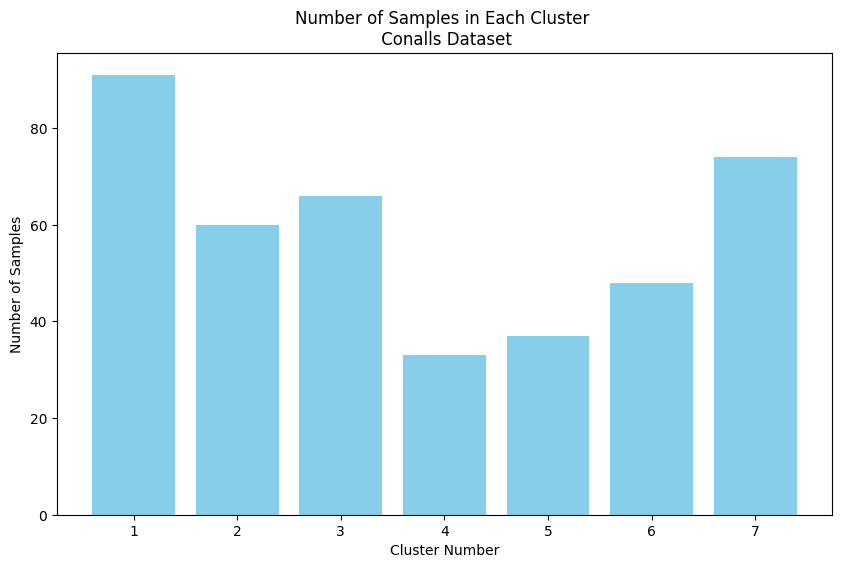

In [25]:
# Count the number of samples in each cluster
sample_counts = np.bincount(cluster_labels)

# Print the total number of samples in each cluster
for cluster, count in enumerate(sample_counts):
    print(f'Cluster {cluster+1} has {count} samples')
    
# Create a bar chart
plt.figure(figsize=(10, 6))
clusters = np.arange(1, len(sample_counts) + 1)
plt.bar(clusters, sample_counts, color='skyblue')

# Add labels and title
plt.xlabel('Cluster Number')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Cluster \n Conalls Dataset')
plt.xticks(clusters)

# Show the bar chart
plt.show()

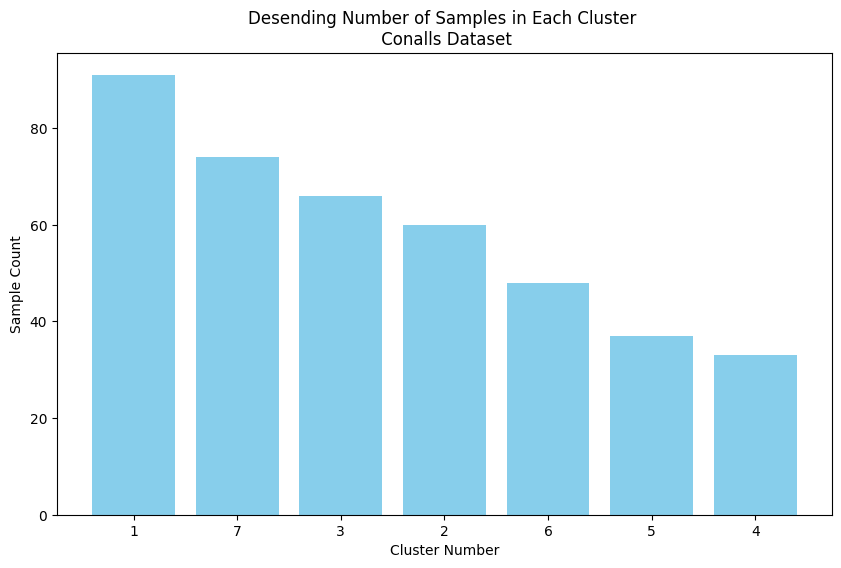

   Cluster  Sample Count
0        1            91
1        7            74
2        3            66
3        2            60
4        6            48
5        5            37
6        4            33


In [26]:
# Count the number of samples in each cluster
sample_counts = np.bincount(cluster_labels)

# Create a DataFrame with cluster information
clusters_df = pd.DataFrame({
    'Cluster': np.arange(1, len(sample_counts) + 1),
    'Sample Count': sample_counts
})

# Sort the DataFrame by 'Sample Count' in descending order
sorted_clusters_df = clusters_df.sort_values(by='Sample Count', ascending=False).reset_index(drop=True)

# Now plot using the sorted DataFrame
plt.figure(figsize=(10, 6))
# The x-coordinates for the bars should be a range with the same number of elements as there are clusters
x_coords = np.arange(len(sorted_clusters_df))
# Now use 'x_coords' for the x-values in the bar plot
plt.bar(x_coords, sorted_clusters_df['Sample Count'], color='skyblue', tick_label=sorted_clusters_df['Cluster'])
plt.xlabel('Cluster Number')
plt.ylabel('Sample Count')
plt.title('Desending Number of Samples in Each Cluster \n Conalls Dataset')
# Use 'x_coords' for setting the x-ticks as well, and label them with the cluster numbers
plt.xticks(x_coords, sorted_clusters_df['Cluster'])
plt.show()

print(sorted_clusters_df)

Named_7_grp
Grp4_HighRisk    85
Grp4_LowRisk     73
SHH_Inf          65
Grp3_HighRisk    65
Grp3_LowRisk     50
SHH_Old          38
WNT              33
MBNOS            19
Name: count, dtype: int64


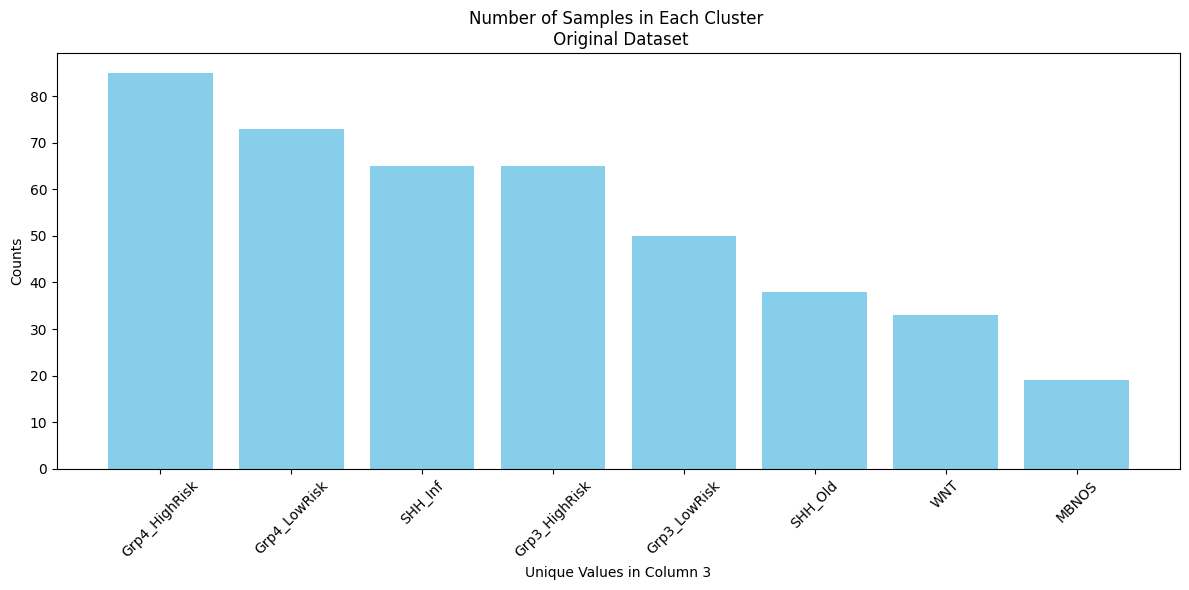

In [27]:
print(column3_counts)

# Create a bar chart
plt.figure(figsize=(12, 6))  # You can adjust the figure size to your liking

# Plotting the bar chart
# The index of column3_counts contains the unique entries,
# and the values are the counts of those entries
plt.bar(column3_counts.index.astype(str), column3_counts.values, color='skyblue')

# Add labels and title
plt.xlabel('Unique Values in Column 3')
plt.ylabel('Counts')
plt.title('Number of Samples in Each Cluster \n Original Dataset')
plt.xticks(rotation=45)  # Rotate x-axis labels if they overlap

# Show the bar chart
plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()

In [28]:
print(cluster_labels)

[0 6 6 2 3 3 6 0 4 0 6 1 2 0 3 6 0 3 6 2 3 0 4 0 2 0 1 0 1 0 0 6 1 4 6 6 2
 1 5 1 6 6 5 1 0 6 6 4 6 0 1 6 0 1 0 0 3 0 6 2 0 6 6 0 3 2 2 0 0 3 0 3 0 0
 1 2 1 4 1 0 0 6 6 6 6 1 2 0 2 6 5 2 5 2 5 5 1 1 5 2 0 4 6 0 3 0 1 0 2 2 6
 6 3 0 0 4 2 6 5 5 6 5 2 3 5 3 0 1 6 3 6 1 0 6 5 6 0 0 6 4 6 3 1 0 4 3 6 6
 3 6 0 5 0 5 0 5 4 3 4 0 4 1 0 0 5 6 1 4 6 2 2 2 2 5 2 2 2 2 5 2 2 5 0 5 5
 5 2 2 2 2 1 4 6 6 1 0 5 0 1 0 0 1 1 1 2 6 0 4 4 6 2 2 2 4 5 5 2 6 0 0 4 1
 6 2 1 1 6 2 5 1 0 5 5 4 6 2 6 2 6 1 2 5 1 1 5 2 4 0 5 3 2 1 2 6 4 2 0 2 2
 2 5 6 5 0 2 5 4 3 3 1 0 2 6 0 0 1 6 4 2 0 2 0 2 0 1 4 3 6 0 0 0 0 4 0 3 1
 5 2 4 0 1 6 5 5 2 3 1 2 1 0 5 4 1 3 1 6 1 1 0 6 0 1 6 1 6 0 5 1 0 0 4 2 4
 6 1 1 1 2 5 0 0 0 2 1 6 5 4 4 4 5 5 6 2 0 3 6 3 0 4 6 5 2 3 5 2 4 6 6 1 1
 0 6 0 1 5 6 0 0 1 3 3 3 0 4 6 2 6 1 6 1 3 0 0 4 5 6 0 2 3 2 1 6 0 0 0 6 4
 0 5]


In [29]:
# Cophenetic Co-efficient
print("Shape of H:", H.shape)
print("Shape of W:", W.shape)
# print("Length of original_row_indices:", len(original_row_indices))
 
# Step 1: Compute pairwise distances
pairwise_dists = pdist(df_H)

# Step 2: Apply hierarchical clustering using the condensed distance matrix
linked = linkage(pairwise_dists, 'ward')  # Correct usage of linkage with precomputed distances

# Step 3: Calculate the cophenetic correlation coefficient
cophenet_corr, coph_dists = cophenet(linked, pairwise_dists)
print(f'Cophenetic Correlation Coefficient: {cophenet_corr}')

Shape of H: (6, 428)
Shape of W: (10000, 6)
Cophenetic Correlation Coefficient: 0.8459863656592719


In [30]:
X = df_H.copy()  # Create a copy to keep the original DataFrame intact

In [31]:
X

,Metagene 1,Metagene 2,Metagene 3,Metagene 4,Metagene 5,Metagene 6
NMB109,0.000000,0.772887,0.000000,0.029754,0.087345,0.002094
NMB110,0.353381,0.497296,0.011920,0.067464,0.058637,0.000000
NMB111,0.481908,0.556757,0.144625,0.022692,0.025931,0.000000
NMB113,0.000000,0.000000,0.063389,0.317821,1.219520,0.007732
NMB115,0.000000,0.050730,1.493839,0.167137,0.082492,0.104233
...,...,...,...,...,...,...
PNET350217,0.020167,0.493800,0.075312,0.078618,0.144701,0.190510
PNET350241,0.093444,0.497686,0.000000,0.261003,0.080687,0.285260
NMB906,0.000000,0.051090,0.000000,1.081813,0.885227,0.061621
NMB915,0.043784,0.532813,0.047755,0.016346,0.137705,0.368607


In [32]:
# Add the cluster labels to your DataFrame
df_H['Cluster'] = cluster_labels

# Group by the cluster labels
clusters = df_H.groupby('Cluster')

# Examine samples in each cluster
# This loop prints out the data for each cluster
for cluster, samples in clusters:
    print(f"Cluster {cluster} has {len(samples)} samples:")
    print(samples)
    print("\n")

Cluster 0 has 91 samples:
            Metagene 1  Metagene 2  Metagene 3  Metagene 4  Metagene 5  \
NMB109        0.000000    0.772887    0.000000    0.029754    0.087345   
NMB119        0.085909    0.605636    0.095388    0.035710    0.359208   
NMB125        0.050559    0.749134    0.000000    0.000000    0.129714   
NMB130        0.012293    0.752445    0.000000    0.000000    0.187525   
NMB134        0.190378    0.713679    0.000000    0.156220    0.073439   
...                ...         ...         ...         ...         ...   
PNET350015    0.117397    0.539909    0.000000    0.000000    0.206110   
PNET350161    0.068077    0.753031    0.025633    0.000000    0.116515   
PNET350198    0.125975    0.472019    0.000000    0.000000    0.191475   
PNET350217    0.020167    0.493800    0.075312    0.078618    0.144701   
NMB915        0.043784    0.532813    0.047755    0.016346    0.137705   

            Metagene 6  Cluster  
NMB109        0.002094        0  
NMB119        0.1

In [33]:
# This was causing an error due to numpy array - 100% accuracy 
# X = df_H.values if isinstance(df_H, pd.DataFrame) else df_H

# Perform hierarchical clustering
Z = linkage(X, 'ward')

# Calculate the cophenetic correlation coefficient
c, coph_dists = cophenet(Z, pdist(X))
print("Cophenetic Correlation Coefficient:", c)

Cophenetic Correlation Coefficient: 0.8459863656592719


In [34]:
# Compute the pairwise distance matrix using pdist
dist_matrix = pdist(X, metric='euclidean')

# Perform hierarchical clustering using the 'ward' method
linkage_matrix = linkage(dist_matrix, method='ward')

# Extract the cophenetic distances from the hierarchical clustering
cophenetic_distances = cophenet(linkage_matrix)
cophenetic_dist = cophenetic_distances[0]

# Convert both distance matrices to ranks
rank_original = pd.Series(dist_matrix).rank()
rank_cophenetic = pd.Series(cophenetic_dist).rank()

# Compute differences and square differences
d = rank_original - rank_cophenetic
d_squared = d**2
sum_d_squared = d_squared.sum()

# Number of observations
n = len(dist_matrix)

# Calculate Spearman's rank correlation coefficient
spearman_corr = 1 - (6 * sum_d_squared) / (n * (n**2 - 1))

print(f"Spearman's rank correlation coefficient: {spearman_corr}")

Spearman's rank correlation coefficient: 0.999998524882434


In [35]:
# # Compute the pairwise distance matrix using pdist
# dist_matrix = pdist(X, metric='euclidean')

# # Perform hierarchical clustering using the 'ward' method
# linkage_matrix = linkage(dist_matrix, method='ward')

# # Extract the cophenetic distances from the hierarchical clustering
# cophenetic_distances = cophenet(linkage_matrix)[0]

# # Reshape the distance matrices to 2D arrays suitable for correlation calculation
# dist_matrix_reshaped = dist_matrix.reshape(1, -1)
# cophenetic_distances_reshaped = cophenetic_distances.reshape(1, -1)

# # Compute Pearson's correlation coefficient between original and cophenetic distances
# ccc = np.corrcoef(dist_matrix_reshaped, cophenetic_distances_reshaped)[0, 1]

# print(f'Cophenetic Correlation Coefficient: {ccc}')

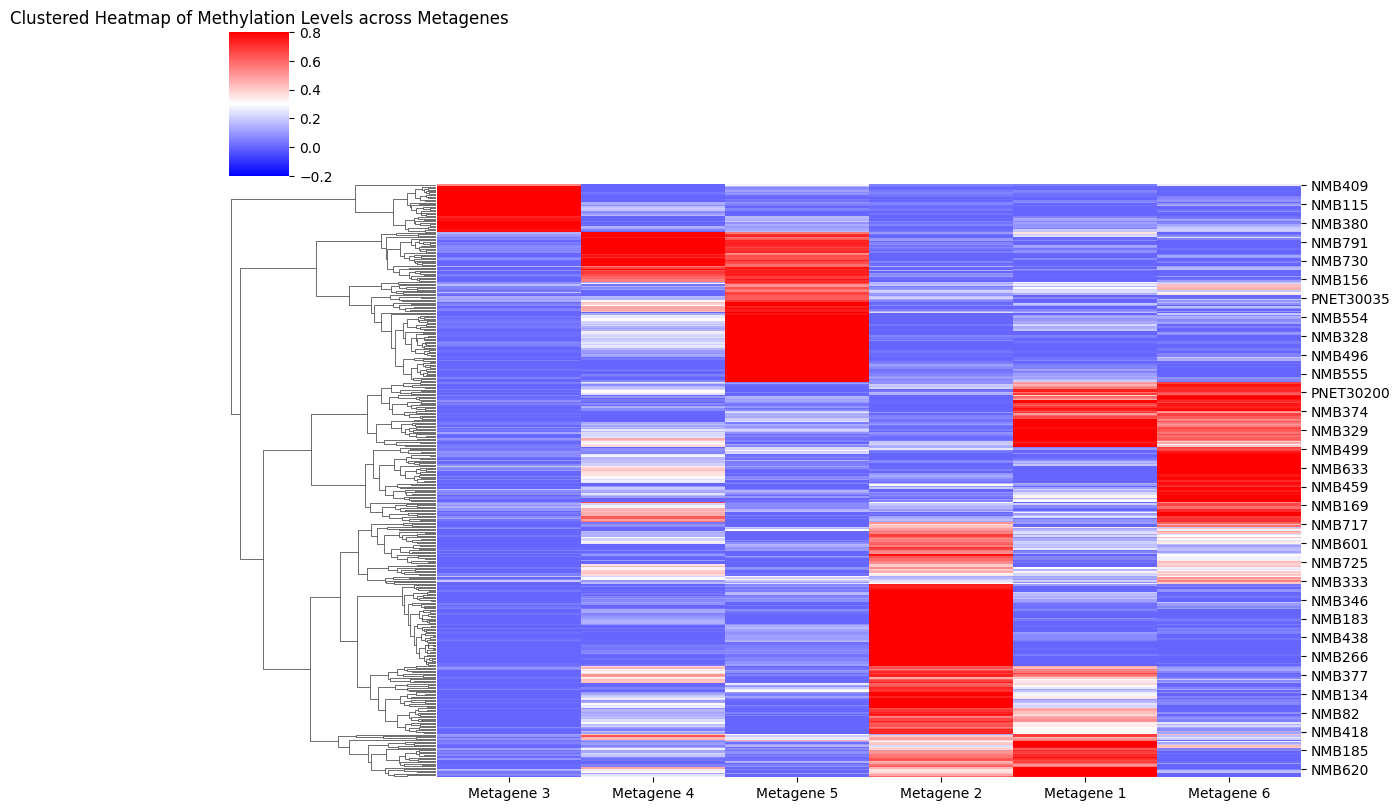

In [36]:
# Another attempt at Clustermap - Incorrect Ordering

color_palette = sns.color_palette("Spectral", n_clusters)

columns_order = ['Metagene 3', 'Metagene 4', 'Metagene 5', 'Metagene 2', 'Metagene 1', 'Metagene 6']

# Ensure all your desired columns are in the dataframe
columns_order = [col for col in columns_order if col in df_H.columns]

# Reorder the dataframe columns
df_H_reordered = df_H[columns_order]

cmap = sns.color_palette("bwr", as_cmap=True)

# Now generate the clustermap without clustering columns since you've specified the order
g = sns.clustermap(df_H_reordered, method='average', metric='euclidean', cmap=cmap, standard_scale=1,
                   figsize=(12, 8), row_cluster=True, col_cluster=False, center=0.3, vmin=-0.2, vmax=0.8)

# Adjusting the labels for readability
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)  # Adjust if necessary
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=0)  # Rotate the x-axis labels for better readability
plt.title('Clustered Heatmap of Methylation Levels across Metagenes')
plt.show()

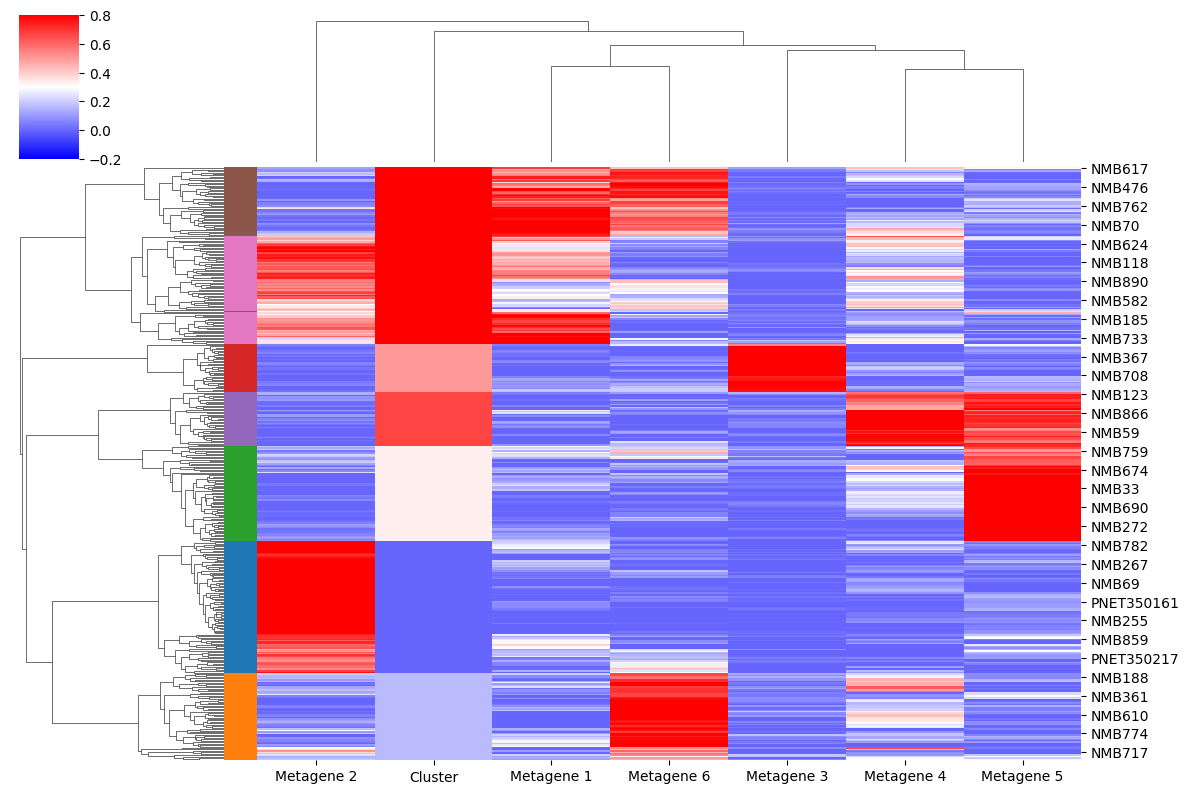

In [37]:
color_palette = sns.color_palette()

# Map cluster labels to colors
cluster_colors = [color_palette[x] for x in cluster_labels]

# Now include row_colors in your clustermap call
sns.clustermap(df_H, figsize=(12, 8), method='average', metric='euclidean', cmap='bwr', standard_scale=1,
               row_cluster=True, col_cluster=True, center=0.3, vmin=-0.2, vmax=0.8, row_colors=cluster_colors)

In [38]:
# Add cluster labels as a column in the DataFrame
df_H['Cluster'] = cluster_labels

print(df_H['Cluster'])

NMB109        0
NMB110        6
NMB111        6
NMB113        2
NMB115        3
             ..
PNET350217    0
PNET350241    6
NMB906        4
NMB915        0
NMB916        5
Name: Cluster, Length: 409, dtype: int32


In [39]:
df_H

,Metagene 1,Metagene 2,Metagene 3,Metagene 4,Metagene 5,Metagene 6,Cluster
NMB109,0.000000,0.772887,0.000000,0.029754,0.087345,0.002094,0
NMB110,0.353381,0.497296,0.011920,0.067464,0.058637,0.000000,6
NMB111,0.481908,0.556757,0.144625,0.022692,0.025931,0.000000,6
NMB113,0.000000,0.000000,0.063389,0.317821,1.219520,0.007732,2
NMB115,0.000000,0.050730,1.493839,0.167137,0.082492,0.104233,3
...,...,...,...,...,...,...,...
PNET350217,0.020167,0.493800,0.075312,0.078618,0.144701,0.190510,0
PNET350241,0.093444,0.497686,0.000000,0.261003,0.080687,0.285260,6
NMB906,0.000000,0.051090,0.000000,1.081813,0.885227,0.061621,4
NMB915,0.043784,0.532813,0.047755,0.016346,0.137705,0.368607,0


In [40]:
df_H.to_csv('df_H_Metagenes_10K_Updated.csv', index=False)

In [41]:
samples19removed_df = df_H.copy()

In [42]:
print("Total From The Study")
print(column3_counts)

Total From The Study
Named_7_grp
Grp4_HighRisk    85
Grp4_LowRisk     73
SHH_Inf          65
Grp3_HighRisk    65
Grp3_LowRisk     50
SHH_Old          38
WNT              33
MBNOS            19
Name: count, dtype: int64


In [43]:
samples19removed_df

,Metagene 1,Metagene 2,Metagene 3,Metagene 4,Metagene 5,Metagene 6,Cluster
NMB109,0.000000,0.772887,0.000000,0.029754,0.087345,0.002094,0
NMB110,0.353381,0.497296,0.011920,0.067464,0.058637,0.000000,6
NMB111,0.481908,0.556757,0.144625,0.022692,0.025931,0.000000,6
NMB113,0.000000,0.000000,0.063389,0.317821,1.219520,0.007732,2
NMB115,0.000000,0.050730,1.493839,0.167137,0.082492,0.104233,3
...,...,...,...,...,...,...,...
PNET350217,0.020167,0.493800,0.075312,0.078618,0.144701,0.190510,0
PNET350241,0.093444,0.497686,0.000000,0.261003,0.080687,0.285260,6
NMB906,0.000000,0.051090,0.000000,1.081813,0.885227,0.061621,4
NMB915,0.043784,0.532813,0.047755,0.016346,0.137705,0.368607,0


In [44]:
# Sort df_H by the cluster labels
df_H_sorted = df_H.sort_values(by='Cluster')

In [45]:
# Re-generate cluster_colors based on the sorted DataFrame
cluster_colors_sorted = [color_palette[x] for x in df_H_sorted['Cluster']]

In [46]:
# Drop the cluster column for visualization
df_H_for_plotting = df_H_sorted.drop('Cluster', axis=1)

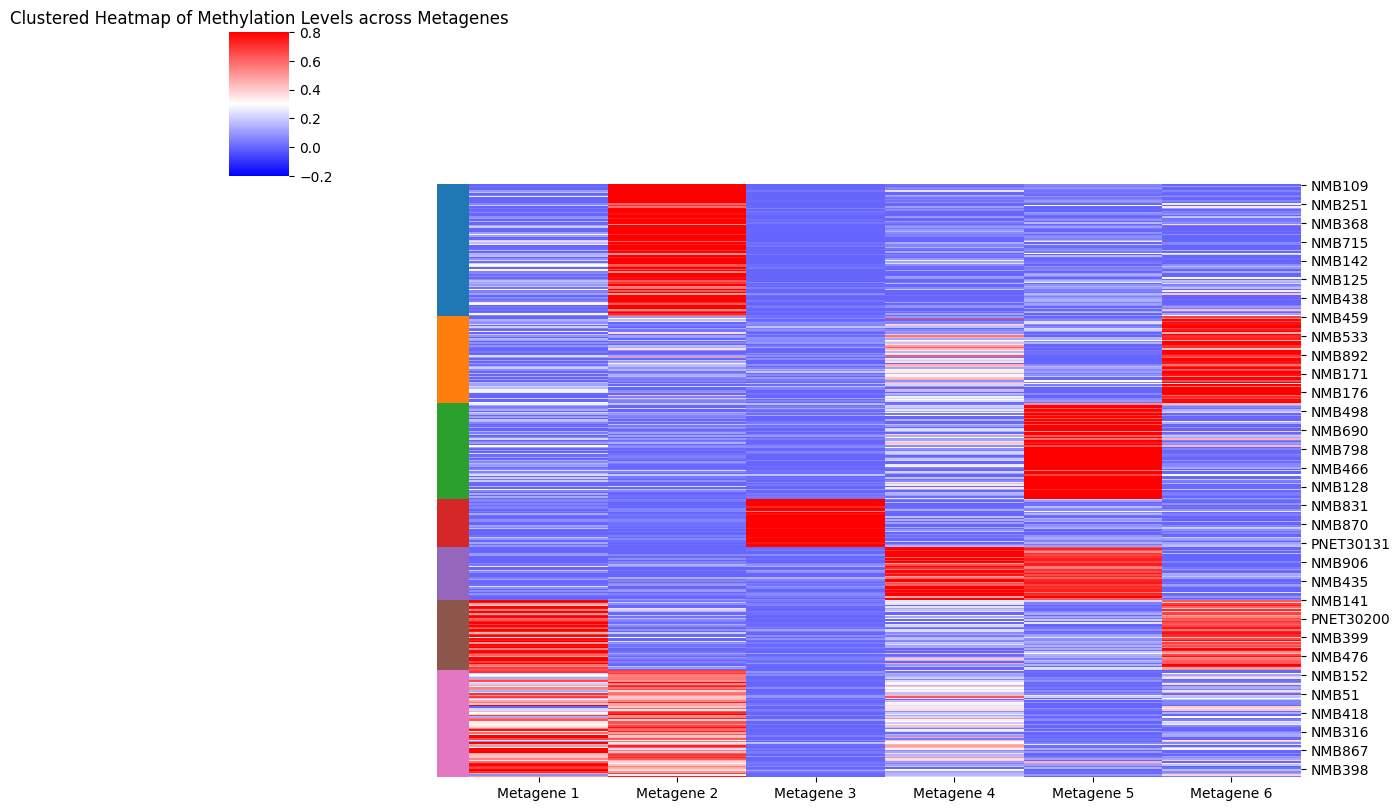

In [47]:
# Plotting the clustermap with the DataFrame sorted by clusters
clusmap = sns.clustermap(df_H_for_plotting, figsize=(12, 8), method='average', metric='euclidean', cmap='bwr', standard_scale=1,
               row_cluster=False, col_cluster=False, center=0.3, vmin=-0.2, vmax=0.8, row_colors=cluster_colors_sorted)

# Adjusting the labels for readability
plt.setp(clusmap.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(clusmap.ax_heatmap.get_xticklabels(), rotation=0)  
plt.title('Clustered Heatmap of Methylation Levels across Metagenes')
plt.show()

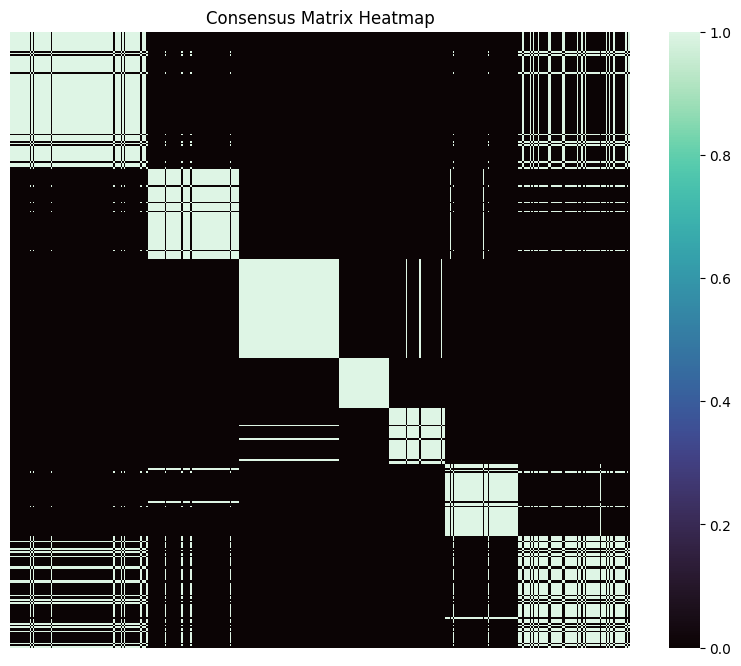

In [48]:
def create_consensus_matrix(data, n_clusters, n_init=100):
    n_samples = data.shape[0]
    consensus_matrix = np.zeros((n_samples, n_samples))
    
    for _ in range(n_init):
        cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
        labels = cluster.fit_predict(data)
        
        # Update the consensus matrix for each pair of samples
        for i in range(n_samples):
            for j in range(n_samples):
                if labels[i] == labels[j]:
                    consensus_matrix[i, j] += 1
    
    # Normalize the consensus matrix by the number of iterations
    consensus_matrix /= n_init
    
    return consensus_matrix

def display_consensus_matrix(consensus_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(consensus_matrix, cmap='mako', xticklabels=False, yticklabels=False)
    plt.title('Consensus Matrix Heatmap')
    plt.show()

# Assuming df_H is your dataset
n_clusters = 7
n_init = 50  # Number of iterations for the consensus matrix creation

# Create and display the consensus matrix
consensus_matrix = create_consensus_matrix(df_H_for_plotting, n_clusters, n_init)
display_consensus_matrix(consensus_matrix)

In [49]:
# Perform hierarchical clustering
Z = linkage(X, 'ward')

# Calculate the cophenetic correlation coefficient
c, coph_dists = cophenet(Z, pdist(X))
print("Cophenetic Correlation Coefficient:", c)

# # Distance matrix computation
# dist_matrix = pdist(X, metric='euclidean')

# # Hierarchical clustering
# linkage_matrix = linkage(dist_matrix, method='ward')

# # Cophenetic distance matrix
# cophenetic_dist_matrix = cophenet(linkage_matrix)

# # Compute Cophenetic Correlation Coefficient
# ccc, _ = spearmanr(dist_matrix, cophenetic_dist_matrix[0])

# print(f'Cophenetic Correlation Coefficient: {ccc}')
# Compute the pairwise distances between observations

original_distances = pdist(X)

# Perform hierarchical clustering using a method, e.g., 'ward', 'single', 'complete', 'average'
Z = linkage(X, method='ward')

# Compute the cophenetic distances
coph_distances, coph_corr = cophenet(Z, original_distances)

# coph_corr is the Cophenetic Correlation Coefficient
print("Cophenetic Correlation Coefficient:", coph_corr)

# Compute the pairwise distances between observations in the dataset
original_distances = pdist(X)

# Perform hierarchical clustering using the 'ward' method (you can choose another if more appropriate)
Z = linkage(X, method='ward')

# Compute the cophenetic distances and the correlation coefficient
coph_distances, coph_corr = cophenet(Z, original_distances)

# Print the Cophenetic Correlation Coefficient
print("Cophenetic Correlation Coefficient:", coph_distances)

Cophenetic Correlation Coefficient: 0.8459863656592719
Cophenetic Correlation Coefficient: [ 3.74553249  3.74553249 13.61954163 ... 13.61954163 13.61954163
  9.77676538]
Cophenetic Correlation Coefficient: 0.8459863656592719


In [50]:
df_H_for_plotting

,Metagene 1,Metagene 2,Metagene 3,Metagene 4,Metagene 5,Metagene 6
NMB109,0.000000,0.772887,0.000000,0.029754,0.087345,0.002094
NMB283,0.017228,0.776340,0.000000,0.000000,0.046266,0.117541
NMB771,0.000000,0.799172,0.000000,0.082050,0.118820,0.000000
NMB646,0.000000,0.812221,0.000000,0.054085,0.059930,0.000000
NMB410,0.071022,0.728579,0.053104,0.302666,0.035503,0.068579
...,...,...,...,...,...,...
NMB182,0.633476,0.308133,0.190893,0.430522,0.001465,0.182659
NMB185,0.486397,0.443116,0.047222,0.149048,0.030001,0.071099
NMB387,0.331025,0.584067,0.000000,0.198780,0.000000,0.122322
NMB2,0.050594,0.294351,0.009281,0.201091,0.132488,0.441225


In [51]:
df_H

,Metagene 1,Metagene 2,Metagene 3,Metagene 4,Metagene 5,Metagene 6,Cluster
NMB109,0.000000,0.772887,0.000000,0.029754,0.087345,0.002094,0
NMB110,0.353381,0.497296,0.011920,0.067464,0.058637,0.000000,6
NMB111,0.481908,0.556757,0.144625,0.022692,0.025931,0.000000,6
NMB113,0.000000,0.000000,0.063389,0.317821,1.219520,0.007732,2
NMB115,0.000000,0.050730,1.493839,0.167137,0.082492,0.104233,3
...,...,...,...,...,...,...,...
PNET350217,0.020167,0.493800,0.075312,0.078618,0.144701,0.190510,0
PNET350241,0.093444,0.497686,0.000000,0.261003,0.080687,0.285260,6
NMB906,0.000000,0.051090,0.000000,1.081813,0.885227,0.061621,4
NMB915,0.043784,0.532813,0.047755,0.016346,0.137705,0.368607,0


Cluster 1: Silhouette Score = 0.804239527256535
Cluster 2: Silhouette Score = 0.699317964894023
Cluster 3: Silhouette Score = 0.7775795239513893
Cluster 4: Silhouette Score = 0.859571047629926
Cluster 5: Silhouette Score = 0.8154941743920382
Cluster 6: Silhouette Score = 0.7163539674524527
Cluster 7: Silhouette Score = 0.6605626673494525


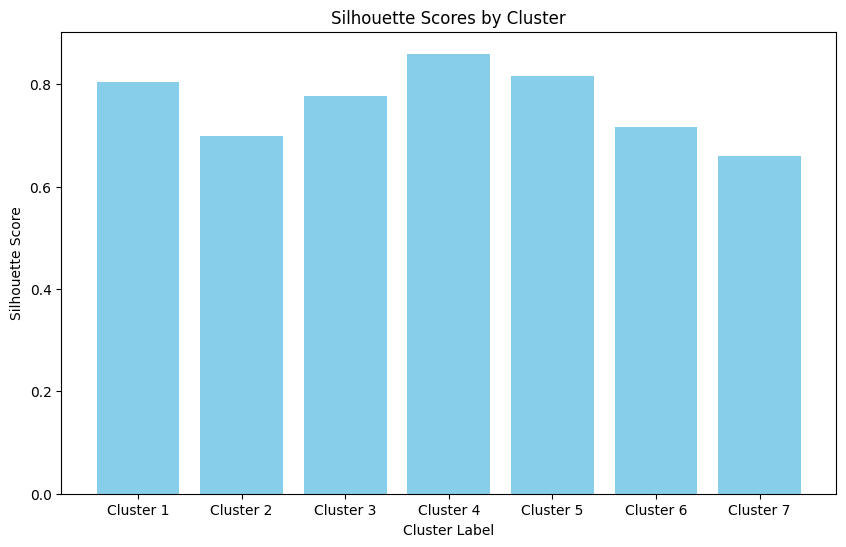

In [52]:
# Silhouette Scores

def silhouette_scores_per_cluster(data, cluster_labels):
    # Calculate silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data, cluster_labels)
    
    # Initialize a dictionary to hold the average silhouette score for each cluster
    scores_per_cluster = {}
    
    # Calculate the average silhouette score for each cluster
    for label in np.unique(cluster_labels):
        # Indices of samples belonging to the current cluster
        cluster_indices = cluster_labels == label
        
        # Average silhouette score for the current cluster
        cluster_silhouette_avg = np.mean(sample_silhouette_values[cluster_indices])
        
        # Store the score in the dictionary
        scores_per_cluster[label] = cluster_silhouette_avg
    
    return scores_per_cluster

# Calculate silhouette scores for each cluster
silhouette_scores = silhouette_scores_per_cluster(df_H, cluster_labels)

# Display the average silhouette scores for each cluster
for cluster, score in silhouette_scores.items():
    print(f'Cluster {cluster+1}: Silhouette Score = {score}')
    
# Creating a bar chart
def plot_silhouette_scores(scores):
    labels = list(scores.keys())
    values = list(scores.values())

    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color='skyblue')
    plt.xlabel('Cluster Label')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores by Cluster')
    plt.xticks(labels, [f'Cluster {label+1}' for label in labels])
    plt.show()

plot_silhouette_scores(silhouette_scores)

In [53]:
# Cophenetic Coefficient Calculation

# def calculate_cophenetic_coefficient(H):
#     # Compute pairwise distances for H matrix
#     pairwise_dists = pdist(H)
#     # Apply hierarchical clustering
#     linked = linkage(H, 'ward')  # 'ward' method is used here
#     # Calculate the cophenetic correlation coefficient
#     cophenet_corr, coph_dists = cophenet(linked, pairwise_dists)
#     return cophenet_corr

# def find_best_factorization_rank(data, min_rank, max_rank):
#     best_rank = min_rank
#     best_cophenetic_coeff = 0

#     for n_components in range(min_rank, max_rank + 1):
#         # Apply NMF
#         _, H, _ = apply_nmf(data, n_components)
#         # Calculate Cophenetic Coefficient
#         cophenet_corr = calculate_cophenetic_coefficient(H)
#         print(f"Rank: {n_components}, Cophenetic Coefficient: {cophenet_corr}")

#         if cophenet_corr > best_cophenetic_coeff:
#             best_cophenetic_coeff = cophenet_corr
#             best_rank = n_components

#     return best_rank, best_cophenetic_coeff

# # Assuming 'methylation_data_top_10000' is your dataset
# best_rank, best_coeff = find_best_factorization_rank(df_H, 3, 10)
# print(f"The best factorization rank is {best_rank} with a Cophenetic Coefficient of {best_coeff}")

In [54]:
df_H

,Metagene 1,Metagene 2,Metagene 3,Metagene 4,Metagene 5,Metagene 6,Cluster
NMB109,0.000000,0.772887,0.000000,0.029754,0.087345,0.002094,0
NMB110,0.353381,0.497296,0.011920,0.067464,0.058637,0.000000,6
NMB111,0.481908,0.556757,0.144625,0.022692,0.025931,0.000000,6
NMB113,0.000000,0.000000,0.063389,0.317821,1.219520,0.007732,2
NMB115,0.000000,0.050730,1.493839,0.167137,0.082492,0.104233,3
...,...,...,...,...,...,...,...
PNET350217,0.020167,0.493800,0.075312,0.078618,0.144701,0.190510,0
PNET350241,0.093444,0.497686,0.000000,0.261003,0.080687,0.285260,6
NMB906,0.000000,0.051090,0.000000,1.081813,0.885227,0.061621,4
NMB915,0.043784,0.532813,0.047755,0.016346,0.137705,0.368607,0


In [55]:
X

,Metagene 1,Metagene 2,Metagene 3,Metagene 4,Metagene 5,Metagene 6
NMB109,0.000000,0.772887,0.000000,0.029754,0.087345,0.002094
NMB110,0.353381,0.497296,0.011920,0.067464,0.058637,0.000000
NMB111,0.481908,0.556757,0.144625,0.022692,0.025931,0.000000
NMB113,0.000000,0.000000,0.063389,0.317821,1.219520,0.007732
NMB115,0.000000,0.050730,1.493839,0.167137,0.082492,0.104233
...,...,...,...,...,...,...
PNET350217,0.020167,0.493800,0.075312,0.078618,0.144701,0.190510
PNET350241,0.093444,0.497686,0.000000,0.261003,0.080687,0.285260
NMB906,0.000000,0.051090,0.000000,1.081813,0.885227,0.061621
NMB915,0.043784,0.532813,0.047755,0.016346,0.137705,0.368607


In [56]:
# # Perform t-SNE
# # X is from Consensus Matrix cell - which is a copy of df_H in that cell, df_H == 428 rows × 6 columns
# tsne = TSNE(n_components=3, random_state=42)
# X_tsne = tsne.fit_transform(X) # X Dataframe used oringally 

# # Plotting
# trace = go.Scatter3d(
#     x=X_tsne[:, 0], y=X_tsne[:, 1], z=X_tsne[:, 2],
#     mode='markers',
#     marker=dict(
#         size=3,
#         color=cluster_labels,  # This assigns a different color for each cluster from kmeans cluster_labels
#         opacity=0.8,
#         colorscale='Rainbow',  
#     )
# )

# data = [trace]
# layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
# fig = go.Figure(data=data, layout=layout)

# fig.show()

In [57]:
# # X is your data and cluster_labels are the labels obtained from some clustering
# tsne = TSNE(n_components=2, random_state=42, perplexity=30)
# X_tsne = tsne.fit_transform(X)

# trace = go.Scatter(
#     x=X_tsne[:, 0], y=X_tsne[:, 1],
#     mode='markers',
#     marker=dict(
#         size=5,
#         color=cluster_labels,  # This assigns a different color for each cluster from kmeans cluster_labels
#         opacity=0.8,
#         colorscale='Rainbow',  
#     )
# )

# data = [trace]
# layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0), xaxis=dict(title='Component 1'), yaxis=dict(title='Component 2'))
# fig = go.Figure(data=data, layout=layout)

# fig.show()

In [58]:
# RANDOM FORREST CREATION 

X_rf = X.copy()

y_rf = cluster_labels.copy() 

# Assuming X is your feature matrix and y is your target vector
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train_rf, y_train_rf)

# Make predictions
y_pred_rf = rf_classifier.predict(X_test_rf)

# Calculate the accuracy
accuracy_rf = accuracy_score(y_test_rf, y_pred_rf)

# Evaluate the model
print("Accuracy:", accuracy_rf)
print(classification_report(y_test_rf, y_pred_rf))

Accuracy: 0.926829268292683
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        20
           1       1.00      0.92      0.96        12
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         9
           5       0.89      1.00      0.94         8
           6       0.82      0.69      0.75        13

    accuracy                           0.93        82
   macro avg       0.94      0.94      0.94        82
weighted avg       0.93      0.93      0.93        82



In [59]:
# SVM MODEL CREATION

# X is already declared and used, as seen above
X_svm = X.copy()

y_svm = cluster_labels.copy() 

# Assuming X is your feature matrix and y is your labels vector
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, test_size=0.2, random_state=42)

# Configure the SVM model
svm_model = SVC(kernel='linear')  # Starting point, linear kernel

# Fit the model
svm_model.fit(X_train_svm, y_train_svm)

# Predict on the test set
predictions_svm = svm_model.predict(X_test_svm)

# Calculate the accuracy
accuracy_svm = accuracy_score(y_test_svm, predictions_svm)

# Print the accuracy
print(f"Accuracy: {accuracy_svm}")

# Evaluate the model
print(classification_report(y_test_svm, predictions_svm))

Accuracy: 0.975609756097561
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.92      0.96        12
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00         8
           6       0.92      0.92      0.92        13

    accuracy                           0.98        82
   macro avg       0.98      0.98      0.98        82
weighted avg       0.98      0.98      0.98        82



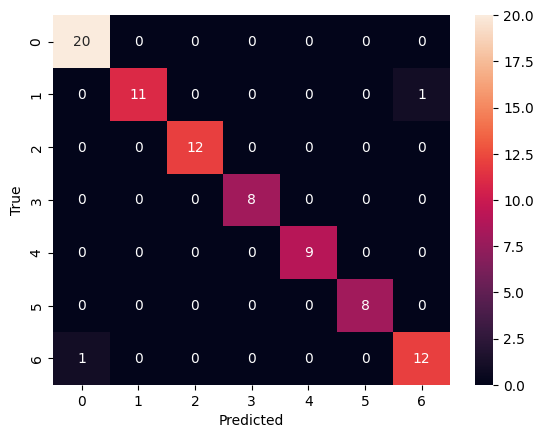

In [60]:
# Compute confusion matrix
cm = confusion_matrix(y_test_svm, predictions_svm)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [61]:
# Parameter grid for GridSearch
param_grid = {
    'C': [0.1, 1, 10, 100],  # C values
    'gamma': [1, 0.1, 0.01, 0.001],  # gamma values
    'kernel': ['rbf', 'poly', 'sigmoid']  # kernels
}

# Create a GridSearchCV object
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=10)

# Fit it to the data
grid_search.fit(X_train_svm, y_train_svm)

# Print out the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Predict using the best model
predictions = grid_search.predict(X_test_svm)

# Evaluate the best model
print(classification_report(y_test_svm, predictions_svm))

Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=

In [62]:
# SVM MODEL AFTER TUNING

X_svmft = X.copy()

y_svmft = cluster_labels.copy() 

label_names = {0: 'Grp4_LowRisk', 1: 'SHH_Inf', 2: 'WNT', 3: 'Grp3_HighRisk', 4: 'SHH_Old', 5: 'Grp4_HighRisk', 6: 'Grp3_LowRisk'}

# Map numerical labels to named labels
y_svmft = np.vectorize(label_names.get)(cluster_labels)

# X is features matrix and y is labels
X_train_svmft, X_test_svmft, y_train_svmft, y_test_svmft = train_test_split(X_svmft, y_svmft, test_size=0.2, random_state=42)

# Configure the SVM model
# svm_model = SVC(C = 10, gamma = 1, kernel = 'poly') 
# svm_model = SVC(C = 100, gamma = 0.1, kernel = 'sigmoid')
# svm_model = SVC(C = 100, gamma = 0.1, kernel = 'rbf', probability=True)
# svm_model_svmft = SVC(C = 1, gamma = 1, kernel = 'sigmoid', probability=True)
svm_model_svmft = SVC(C = 10, gamma = 0.1, kernel = 'sigmoid', probability=True)
# svm_model_svmft = SVC(C = 1, gamma = 1, kernel = 'rbf', probability=True) 
# svm_model = SVC(C = 0.1, gamma = 1, kernel = 'rbf', probability=True)

# Fit the model
svm_model_svmft.fit(X_train_svmft, y_train_svmft)

# Predict on the test set
predictions_svmft = svm_model_svmft.predict(X_test_svmft)

# Probability distribuation across classes
probabilities_svmft = svm_model_svmft.predict_proba(X_test_svmft)

# Calculate the accuracy
accuracy_svmft = accuracy_score(y_test_svmft, predictions_svmft)

# Print the accuracy
print(f"Accuracy: {accuracy_svmft}")
# Evaluate the model
print(classification_report(y_test_svmft, predictions_svmft))

Accuracy: 0.975609756097561
               precision    recall  f1-score   support

Grp3_HighRisk       1.00      1.00      1.00         8
 Grp3_LowRisk       0.92      0.92      0.92        13
Grp4_HighRisk       1.00      1.00      1.00         8
 Grp4_LowRisk       0.95      1.00      0.98        20
      SHH_Inf       1.00      0.92      0.96        12
      SHH_Old       1.00      1.00      1.00         9
          WNT       1.00      1.00      1.00        12

     accuracy                           0.98        82
    macro avg       0.98      0.98      0.98        82
 weighted avg       0.98      0.98      0.98        82



In [63]:
# # Creating 2 variables based on fine tuned model 
# probabilities = probabilities_svmft

# predictions = predictions_svmft

# def resample_data(data, max_samples=8, sample_size=0.8):
#     n_samples = random.randint(1, max_samples)  # Random number of samples between 1 and max_samples
#     samples = []
#     for _ in range(n_samples):
#         sample_indices = np.random.choice(len(data), size=int(len(data) * sample_size), replace=True)
#         samples.append(data[sample_indices])
#     return samples

# def bootstrap_confidence_intervals(samples):
#     intervals = []
#     for sample in samples:
#         mean_sample = np.mean(sample)
#         stats = [np.mean(sample[np.random.choice(len(sample), len(sample), replace=True)]) for _ in range(1000)]
#         lower = np.percentile(stats, 2.5)
#         upper = np.percentile(stats, 97.5)
#         intervals.append((mean_sample, lower, upper))
#     return intervals

# data = []  
# intervals = []
# labels = []
# positions = []
# base_position = 1
# tick_positions = []  # To store the x-tick positions for labels
# plotted_labels = []  # To store labels actually plotted

# class_labels = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'NC']
# colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'grey']
# color_assignment = []

# for i in range(6):  
#     class_probs = probabilities[(predictions == i) & (probabilities[:, i] >= 0.73), i]
#     if len(class_probs) > 0:
#         resampled_data = resample_data(class_probs)
#         data.extend(resampled_data)
#         sample_intervals = bootstrap_confidence_intervals(resampled_data)
#         intervals.extend(sample_intervals)
#         labels.extend([class_labels[i]] * len(resampled_data))
#         positions.extend(range(base_position, base_position + len(resampled_data)))
#         color_assignment.extend([colors[i]] * len(resampled_data))
#         tick_positions.append(base_position + len(resampled_data) // 2)
#         plotted_labels.append(class_labels[i])
#         base_position += len(resampled_data) + 1
#         print(f"Metagene {class_labels[i]}: Sample Values, Mean, CI Lower, CI Upper")
#         for val, (mean, ci_lower, ci_upper) in zip(resampled_data, sample_intervals):
#             print(f"Values: {val}, Mean: {mean:.4f}, CI: ({ci_lower:.4f}, {ci_upper:.4f})")
#     else:
#         base_position += 2

# nc_probs = probabilities[np.all(probabilities < 0.73, axis=1)]
# if len(nc_probs) > 0:
#     nc_resampled_data = resample_data(nc_probs.max(axis=1))
#     data.extend(nc_resampled_data)
#     sample_intervals = bootstrap_confidence_intervals(nc_resampled_data)
#     intervals.extend(sample_intervals)
#     labels.extend(['NC'] * len(nc_resampled_data))
#     positions.extend(range(base_position, base_position + len(nc_resampled_data)))
#     color_assignment.extend([colors[6]] * len(nc_resampled_data))
#     tick_positions.append(base_position + len(nc_resampled_data) // 2)
#     plotted_labels.append('NC')
#     base_position += len(nc_resampled_data) + 1
#     print(f"Non-Classifiable (NC): Sample Values, Mean, CI Lower, CI Upper")
#     for val, (mean, ci_lower, ci_upper) in zip(nc_resampled_data, sample_intervals):
#         print(f"Values: {val}, Mean: {mean:.4f}, CI: ({ci_lower:.4f}, {ci_upper:.4f}")
        
# else:
#     base_position += 2

# plt.figure(figsize=(12, 8))
# bp = plt.boxplot(data, patch_artist=True, positions=positions, notch=True, vert=True, showfliers=True)
# for patch, color in zip(bp['boxes'], color_assignment):
#     patch.set_facecolor(color)

# plt.xticks(tick_positions, plotted_labels)
# plt.axhline(y=0.73, color='r', linestyle='--')
# plt.title('Classifier Predictions with Probability Thresholds and Confidence Intervals')
# plt.ylabel('Probability')
# plt.ylim(0, 1)
# plt.grid(True)
# plt.show()

In [64]:
# def resample_data(data, max_samples=5, sample_size=0.8):
#     n_samples = random.randint(1, max_samples)  # Random number of samples between 1 and max_samples
#     samples = []
#     for _ in range(n_samples):
#         sample_indices = np.random.choice(len(data), size=int(len(data) * sample_size), replace=True)
#         samples.append(data[sample_indices])
#     return samples

# def bootstrap_confidence_intervals(samples):
#     intervals = []
#     for sample in samples:
#         stats = [np.mean(sample[np.random.choice(len(sample), len(sample), replace=True)]) for _ in range(1000)]
#         lower = np.percentile(stats, 2.5)
#         upper = np.percentile(stats, 97.5)
#         intervals.append((lower, upper))
#     return intervals

# data = []  
# intervals = []
# labels = []
# positions = []
# base_position = 1
# tick_positions = []  # To store the x-tick positions for labels
# plotted_labels = []  # To store labels actually plotted

# class_labels = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'NC']
# colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'grey']
# color_assignment = []

# for i in range(6):  
#     class_probs = probabilities[(predictions == i) & (probabilities[:, i] >= 0.73), i]
#     if len(class_probs) > 0:
#         resampled_data = resample_data(class_probs)
#         data.extend(resampled_data)
#         intervals.extend(bootstrap_confidence_intervals(resampled_data))
#         labels.extend([class_labels[i]] * len(resampled_data))
#         positions.extend(range(base_position, base_position + len(resampled_data)))
#         color_assignment.extend([colors[i]] * len(resampled_data))
#         tick_positions.append(base_position + len(resampled_data) // 2)
#         plotted_labels.append(class_labels[i])
#         base_position += len(resampled_data) + 1

# nc_probs = probabilities[np.all(probabilities < 0.73, axis=1)]
# if len(nc_probs) > 0:
#     nc_resampled_data = resample_data(nc_probs.max(axis=1))
#     data.extend(nc_resampled_data)
#     intervals.extend(bootstrap_confidence_intervals(nc_resampled_data))
#     labels.extend(['NC'] * len(nc_resampled_data))
#     positions.extend(range(base_position, base_position + len(nc_resampled_data)))
#     color_assignment.extend([colors[6]] * len(nc_resampled_data))
#     tick_positions.append(base_position + len(nc_resampled_data) // 2)
#     plotted_labels.append('NC')
#     base_position += len(nc_resampled_data) + 1

# plt.figure(figsize=(12, 8))
# bp = plt.boxplot(data, patch_artist=True, positions=positions, notch=True, vert=True, showfliers=True)
# for patch, color in zip(bp['boxes'], color_assignment):
#     patch.set_facecolor(color)
    
# # Set custom x-ticks to the calculated tick positions
# plt.xticks(tick_positions, plotted_labels)
# plt.axhline(y=0.73, color='r', linestyle='--')
# plt.title('Classifier Predictions with Probability Thresholds and Confidence Intervals')
# plt.ylabel('Probability')
# plt.ylim(0, 1)
# plt.grid(True)
# plt.show()

In [65]:
# # Compute confusion matrix
# cm = confusion_matrix(y_test_svmft, predictions_svmft)

# # Visualize the confusion matrix
# sns.heatmap(cm, annot=True, fmt='d')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

In [66]:

# # USE THIS IF 428 SAMPLES ARE BEING USED IN THE DATASET 

# # n = 428 Samples

# # Extract the Original Labels
# other_labels = od[column3_name]

# # Your provided label mapping
# label_mapping = {
#     0: 'Grp3_HighRisk',
#     6: 'Grp3_LowRisk',
#     4: 'Grp4_HighRisk',
#     2: 'Grp4_LowRisk',
#     1: 'SHH_Inf',
#     5: 'SHH_Old',
#     3: 'WNT'
# }

# # Assuming `cluster_labels` is a numpy array, convert it to a pandas Series
# cluster_labels_series = pd.Series(cluster_labels)

# # Apply the mapping to rename clusters
# renamed_clusters_series = cluster_labels_series.map(label_mapping)

# # If you need the result back as a numpy array
# renamed_clusters = renamed_clusters_series.to_numpy()

# # Assuming `reorganized_labels` should be `renamed_clusters_series` for the DataFrame comparison
# data_for_comparison = pd.DataFrame({
#     'MyClusters': renamed_clusters_series,  # Use renamed clusters for direct comparison
#     'ReorganizedLabels': other_labels  # Assuming `other_labels` are already in a comparable format
# })

# # Construct the Confusion Matrix using the corrected column
# conf_matrix = pd.crosstab(data_for_comparison['ReorganizedLabels'], data_for_comparison['MyClusters'])

# conf_matrix_dropped_MBNOS = conf_matrix.drop('MBNOS')

# # Display the Confusion Matrix
# print(conf_matrix_dropped_MBNOS)

# # # Visualize the Confusion Matrix
# # plt.figure(figsize=(14, 12))
# # sns.heatmap(conf_matrix_dropped_MBNOS, annot=True, fmt="d", cmap="Blues")
# # plt.title('Confusion Matrix')
# # plt.xlabel('My Labels')
# # plt.ylabel('Reza\'s Labels')
# # plt.show()

In [67]:
# # n = 409 Samples 

# # Extract the Original Labels
# other_labels = od[column3_name]

# # Your provided label mapping
# label_mapping = {
#     5: 'Grp3_HighRisk',
#     0: 'Grp3_LowRisk',
#     2: 'Grp4_HighRisk',
#     6: 'Grp4_LowRisk',
#     1: 'SHH_Inf',
#     4: 'SHH_Old',
#     3: 'WNT'
# }

# # Assuming `cluster_labels` is a numpy array, convert it to a pandas Series
# cluster_labels_series = pd.Series(cluster_labels)

# # Apply the mapping to rename clusters
# renamed_clusters_series = cluster_labels_series.map(label_mapping)

# # If you need the result back as a numpy array
# renamed_clusters = renamed_clusters_series.to_numpy()

# # Assuming `reorganized_labels` should be `renamed_clusters_series` for the DataFrame comparison
# data_for_comparison = pd.DataFrame({
#     'MyClusters': renamed_clusters_series,  # Use renamed clusters for direct comparison
#     'ReorganizedLabels': other_labels  # Assuming `other_labels` are already in a comparable format
# })

# # Construct the Confusion Matrix using the corrected column
# conf_matrix = pd.crosstab(data_for_comparison['ReorganizedLabels'], data_for_comparison['MyClusters'])

# conf_matrix_dropped_MBNOS = conf_matrix.drop('MBNOS')

# # Display the Confusion Matrix
# print(conf_matrix_dropped_MBNOS)

# # Visualize the Confusion Matrix
# plt.figure(figsize=(14, 12))
# sns.heatmap(conf_matrix_dropped_MBNOS, annot=True, fmt="d", cmap="Blues")
# plt.title('Confusion Matrix')
# plt.xlabel('My Labels')
# plt.ylabel('Reza\'s Labels')
# plt.show()

In [68]:
# Save the model
dump(svm_model_svmft, 'svm_model.joblib')

['svm_model.joblib']

In [69]:
# print(cluster_labels_series)

In [70]:
# print(renamed_clusters)

In [71]:
print(svm_model)

SVC(kernel='linear')


In [72]:
# od[column3_name].dtype

# od_labels = od[column3_name].astype('str')

# od_labels = od[column3_name].str.replace('MBNOS', '', regex=False)

# od_labels_MBNOS_removed = od_labels.dropna()

# od_filtered = od[od['Named_7_grp'] != 'MBNOS']

# od_labels_MBNOS_removed = od_filtered['Named_7_grp']

# print(od_labels_MBNOS_removed)

# def map_groups_to_numbers(group_list):
#     # Mapping based on your provided order
#     group_mapping = {
#         'Grp3_HighRisk': 0,
#         'Grp3_LowRisk': 1,
#         'Grp4_HighRisk': 2,
#         'Grp4_LowRisk': 3,
#         'SHH_Inf': 4,
#         'SHH_Old': 5,
#         'WNT': 6
#     }

#     # Convert each group in the list to its corresponding number
#     num_array_orginal_labels = [group_mapping[group] for group in group_list]

#     return num_array_orginal_labels

# original_cluster_array = map_groups_to_numbers(od_labels_MBNOS_removed)

# print(original_cluster_array)

# print("BREAK")

# print("BREAK")

# print("BREAK")

# print("BREAK")

# print(map_groups_to_numbers(renamed_clusters))

# print(renamed_clusters)


In [73]:
# # Create DataFrames (making sure they are the same length)
# df1 = pd.DataFrame({'clusters': od_labels_MBNOS_removed}) 
# df2 = pd.DataFrame({'clusters': renamed_clusters})

# # Ensure both dataframes have the same length
# if len(df1) != len(df2):
#    print("Warning: DataFrames have different lengths!")

# # Create the confusion matrix
# cm = confusion_matrix(df1['clusters'], df2['clusters']) 

# # Get unique labels for the tick marks
# tick_marks = range(len(set(df1['clusters']).union(df2['clusters'])))

# # Visualize with Heatmap
# plt.figure(figsize=(8,6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tick_marks, yticklabels=tick_marks)
# plt.xlabel("Predicted Clusters (renamed)")
# plt.ylabel("True Clusters (od_labels)")
# plt.xticks(rotation=45)  # Optional: to rotate x-axis labels for better readability
# plt.yticks(rotation=0)   # Optional: to rotate y-axis labels for better readability
# plt.show()

In [74]:
# # Count the number of samples in each cluster for both dataframes
# cluster_counts_df1 = df1['clusters'].value_counts().sort_index()
# cluster_counts_df2 = df2['clusters'].value_counts().sort_index()

# # Create a dataframe to hold the counts for easier comparison
# comparison_df = pd.DataFrame({
#     'Cluster': cluster_counts_df1.index,
#     'Count_DF1': cluster_counts_df1.values,
#     'Count_DF2': cluster_counts_df2.reindex(cluster_counts_df1.index, fill_value=0).values  # reindex to ensure matching
# })

# # Print the comparison
# print(comparison_df)

In [75]:
# # Count the number of samples in each cluster for both dataframes
# cluster_counts_df1 = df1['clusters'].value_counts().sort_index()
# cluster_counts_df2 = df2['clusters'].value_counts().sort_index()

# # Create a dataframe to hold the counts for easier comparison
# comparison_df = pd.DataFrame({
#     'Cluster': cluster_counts_df1.index,
#     'Count_DF1': cluster_counts_df1.values,
#     'Count_DF2': cluster_counts_df2.values  # reindex to ensure matching
# })

# # Print the comparison
# print(comparison_df)

In [76]:
print(cm)

[[20  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  1]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0  8  0  0  0]
 [ 0  0  0  0  9  0  0]
 [ 0  0  0  0  0  8  0]
 [ 1  0  0  0  0  0 12]]


In [77]:
# ari = adjusted_rand_score(df1['clusters'], df2['clusters'])
# nmi = normalized_mutual_info_score(df1['clusters'], df2['clusters'], average_method='arithmetic')

# print(f'Adjusted Rand Index: {ari}')
# print(f'Normalized Mutual Information: {nmi}')

In [78]:
# # Cluster number mapping
# cluster_mapping = {
#     4: 'Grp3_HighRisk',
#     6: 'Grp3_LowRisk',
#     2: 'Grp4_HighRisk',
#     5: 'Grp4_LowRisk',
#     1: 'SHH_Inf',
#     0: 'SHH_Old',
#     3: 'WNT'
# }

# # Desired order based on label_mapping
# desired_order = list(label_mapping.keys())

# # Get cluster names with the desired order
# cluster_names = [label_mapping[i] for i in desired_order]

# # Reorder the confusion matrix
# cm_reordered = cm[desired_order, :]  # Reorder rows
# cm_reordered = cm_reordered[:, desired_order]  # Reorder columns

# # Create the heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm_reordered, annot=True, fmt='d', cmap='Blues', xticklabels=cluster_names, yticklabels=cluster_names)
# plt.xlabel("Predicted Clusters")
# plt.ylabel("True Clusters")
# plt.show()

In [79]:
# # Assuming X is your data and cluster_labels are the labels obtained from some clustering
# tsne = TSNE(n_components=2, random_state=42)
# X_tsne = tsne.fit_transform(X)

# trace = go.Scatter(
#     x=X_tsne[:, 0], y=X_tsne[:, 1],
#     mode='markers',
#     marker=dict(
#         size=5,
#         color=cluster_labels,  # Assigns a different color for each cluster
#         opacity=0.8,
#         colorscale='Rainbow',  # Optional, adjust as needed
#     )
# )

# data = [trace]
# layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0), xaxis=dict(title='Component 1'), yaxis=dict(title='Component 2'))
# fig = go.Figure(data=data, layout=layout)

# fig.show()

In [80]:
X

,Metagene 1,Metagene 2,Metagene 3,Metagene 4,Metagene 5,Metagene 6
NMB109,0.000000,0.772887,0.000000,0.029754,0.087345,0.002094
NMB110,0.353381,0.497296,0.011920,0.067464,0.058637,0.000000
NMB111,0.481908,0.556757,0.144625,0.022692,0.025931,0.000000
NMB113,0.000000,0.000000,0.063389,0.317821,1.219520,0.007732
NMB115,0.000000,0.050730,1.493839,0.167137,0.082492,0.104233
...,...,...,...,...,...,...
PNET350217,0.020167,0.493800,0.075312,0.078618,0.144701,0.190510
PNET350241,0.093444,0.497686,0.000000,0.261003,0.080687,0.285260
NMB906,0.000000,0.051090,0.000000,1.081813,0.885227,0.061621
NMB915,0.043784,0.532813,0.047755,0.016346,0.137705,0.368607


In [81]:
# # Assume df is your DataFrame and does not include the target variable or labels
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(methylation_data_top_10000)

In [82]:
X_scaled

array([[0.93802273, 0.9225684 , 0.97083863, ..., 0.0740467 , 0.92618625,
        0.80231342],
       [0.93767969, 0.89209566, 0.95353233, ..., 0.77089719, 0.22761413,
        0.92921727],
       [0.97103631, 0.96319   , 0.98269178, ..., 0.07529882, 0.12045973,
        0.29119029],
       ...,
       [0.19057664, 0.14813711, 0.15242912, ..., 0.78694243, 0.24485164,
        0.26975071],
       [0.72994225, 0.91480805, 0.90676504, ..., 0.10524539, 0.88560009,
        0.42284776],
       [0.03096562, 0.2137382 , 0.07639842, ..., 0.46967615, 0.04854182,
        0.05735675]])

In [83]:
# # Transform data to be non-negative using MinMaxScaler
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(df_ci)

# # Apply NMF
# nmf = NMF(n_components=6, init='random', random_state=42, max_iter=1000)
# X_reduced = nmf.fit_transform(X_scaled)

In [84]:
y = cluster_labels.copy()  # This is obtained from your previous k-Means step

# Train SVM
# svm = SVC(C = 1, gamma = 1, kernel = 'sigmoid', probability=True)  # You can choose the kernel based on your specific needs
# svm.fit(X_reduced, y)

In [85]:
# def bootstrap_confidence_interval(data, labels, n_iterations=1000):
#     accuracies = []
#     n = len(data)
    
#     for _ in range(n_iterations):
#         indices = np.random.choice(range(n), size=n, replace=True)
#         data_sample = data[indices]
#         labels_sample = labels[indices]
        
#         svm = SVC(kernel='linear', random_state=42)
#         svm.fit(data_sample, labels_sample)
#         pred_labels = svm.predict(data_sample)
        
#         acc = accuracy_score(labels_sample, pred_labels)
#         accuracies.append(acc)
    
#     accuracies = np.array(accuracies)
#     mean_accuracy = np.mean(accuracies)
#     ci_lower = np.percentile(accuracies, 2.5)
#     ci_upper = np.percentile(accuracies, 97.5)
    
#     return mean_accuracy, ci_lower, ci_upper

# # Call the function using X_reduced and y
# mean_acc, ci_low, ci_up = bootstrap_confidence_interval(X_reduced, y)
# print(f"Mean Accuracy: {mean_acc}, 95% CI: [{ci_low}, {ci_up}]")

In [86]:
# from lazypredict.Supervised import LazyClassifier
# from sklearn.model_selection import train_test_split

# # data = load_breast_cancer()
# # X = data.data
# # y= data.target

# X_train, X_test, y_train, y_test = train_test_split(df_ci, y,test_size=0.2,random_state =123)

# clf = LazyClassifier(verbose=1,ignore_warnings=True, custom_metric=None)
# models,predictions = clf.fit(X_train, X_test, y_train, y_test)

# print(models)

In [87]:
# from sklearn.model_selection import StratifiedKFold

# # Split data into features and target variable
# X = df_ci
# y = y

# # Define the number of folds for cross-validation
# n_folds = 5

# # Define a stratified K-Fold object
# skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=123)

# # Initialize lists to store scores
# accuracy_scores = []
# balanced_accuracy_scores = []
# roc_auc_scores = []
# f1_scores = []

# # Iterate over each fold
# for train_index, test_index in skf.split(X, y):
#     # Split data into training and testing sets
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     # Train the model
#     clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
#     models,predictions = clf.fit(X_train, X_test, y_train, y_test)

#     # Evaluate the model performance
#     accuracy_scores.append(accuracy_score(y_test, predictions))
#     balanced_accuracy_scores.append(balanced_accuracy_score(y_test, predictions))
#     roc_auc_scores.append(roc_auc_score(y_test, predictions))
#     f1_scores.append(f1_score(y_test, predictions))

# # Print the average scores
# print("Average Accuracy:", np.mean(accuracy_scores))
# print("Average Balanced Accuracy:", np.mean(balanced_accuracy_scores))
# print("Average ROC AUC:", np.mean(roc_auc_scores))
# print("Average F1 Score:", np.mean(f1_scores))